## Adjoint derivatives tutorial: A shallow water model

In this tutorial we aim to demonstrate to users how one can use Enzyme + Checkpointing in Julia to compute derivatives of a shallow water model and provide physical interpretations of the computed derivatives. 

### Model overview

The differentiable model we'll examine in this tutorial is a **shallow water model**. This just means we're examining a simplified ocean model: imagine a box of fluid with wind-driven circulation. The equations of motion are given by 

$$
\begin{align}
        \frac{\partial}{\partial t} u + u \frac{\partial}{\partial x} u + v \frac{\partial}{\partial y} u - fv &= - g \frac{\partial}{\partial x} \eta + F_x + M_x \\
	\frac{\partial}{\partial t} v + u \frac{\partial}{\partial x} v + v \frac{\partial}{\partial y} v + fv &= - g \frac{\partial}{\partial y} \eta + F_y + M_y  \\
        \frac{\partial }{\partial t} \eta + \nabla \cdot (h \mathbf{u}) &= 0
\end{align}
$$
with the various parameters and forcings defined as:
$$
\begin{align}
\text{Velocity vector:}& \; \; \mathbf{u} = (u(t, x,y), v(t,x,y)) \\
\text{Surface displacement:}& \; \; \eta(t, x, y) \\
\text{Coriolis function:}& \; \;  f = f(y) = f_0 + \beta y \\
\text{Gravity constant:}& \; \; g \\
\text{Wind forcing:}& \; \; \mathbf{F} = (F_x, F_y) \\
\text{Energy dissipation terms:}& \; \; \mathbf{M} = (M_x, M_y)
\end{align}
$$


All of the code to run the shallow water model is contained in a single Julia package ShallowWaters.jl. Let's add this now! (We'll also add Plots.jl here, to look at the output)

In [2]:
using ShallowWaters#main
using Plots

Once ShallowWaters is installed, we can easily look at a simulation, let's try a barotropic gyre. This next cell sets up the parameters we want the model to use, and runs the integration. 

In [3]:
Prog = run_model(
    L_ratio=1,
    g=9.81,
    H=500,
    wind_forcing_x="double_gyre",
    Lx=3840e3,
    seasonal_wind_x=false,
    topography="flat",
    bc="nonperiodic",
    α=2,
    nx=128,
    Ndays = 365
);

Starting ShallowWaters on Tue, 14 May 2024 13:27:41 without output.
100% Integration done in 36.1s.


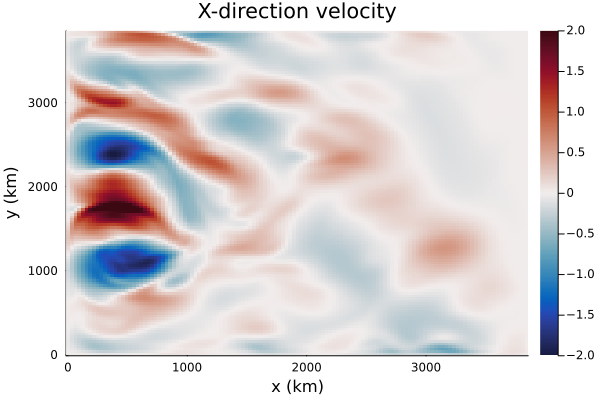

In [4]:
heatmap(LinRange(0, 3840, 127),
    LinRange(0, 3840, 128),
    Prog.u',
    c=:balance,
    clim=(-2,2),
    title="X-direction velocity",
    xlabel="x (km)",
    ylabel="y (km)"
)

## Computing derivatives

Now we can begin to actually compute derivatives! First we need to include some packages. The first two are Enzyme.jl and Checkpointing.jl:

In [6]:
using Enzyme
using Checkpointing
Enzyme.API.maxtypeoffset!(3500)
Enzyme.API.runtimeActivity!(true)

Enzyme.jl is needed to generate and compile the model derivative code, Checkpointing.jl is needed to checkpoint the backwards differentiation process.

In [7]:
using Parameters

We need a modified version of the integration defined in ShallowWaters.jl, one that

1. implements Checkpointing.jl during the integration, and

2. returns the value of a loss function, rather than the prognostic variables

We define that here. The function `checkpointed_integration` initializes the integration process, and `loop` will be the checkpointed timestepping loop. The return value, or loss function, is defined at the end of `loop`.

In [8]:
function checkpointed_integration(S, scheme)

    # setup
    Diag = S.Diag
    Prog = S.Prog

    @unpack u,v,η,sst = Prog
    @unpack u0,v0,η0 = Diag.RungeKutta
    @unpack u1,v1,η1 = Diag.RungeKutta
    @unpack du,dv,dη = Diag.Tendencies
    @unpack du_sum,dv_sum,dη_sum = Diag.Tendencies
    @unpack du_comp,dv_comp,dη_comp = Diag.Tendencies

    @unpack um,vm = Diag.SemiLagrange

    @unpack dynamics,RKo,RKs,tracer_advection = S.parameters
    @unpack time_scheme,compensated = S.parameters
    @unpack RKaΔt,RKbΔt = S.constants
    @unpack Δt_Δ,Δt_Δs = S.constants

    @unpack nt,dtint = S.grid
    @unpack nstep_advcor,nstep_diff,nadvstep,nadvstep_half = S.grid

    # calculate layer thicknesses for initial conditions
    ShallowWaters.thickness!(Diag.VolumeFluxes.h,η,S.forcing.H)
    ShallowWaters.Ix!(Diag.VolumeFluxes.h_u,Diag.VolumeFluxes.h)
    ShallowWaters.Iy!(Diag.VolumeFluxes.h_v,Diag.VolumeFluxes.h)
    ShallowWaters.Ixy!(Diag.Vorticity.h_q,Diag.VolumeFluxes.h)

    # calculate PV terms for initial conditions
    urhs = convert(Diag.PrognosticVarsRHS.u,u)
    vrhs = convert(Diag.PrognosticVarsRHS.v,v)
    ηrhs = convert(Diag.PrognosticVarsRHS.η,η)

    ShallowWaters.advection_coriolis!(urhs,vrhs,ηrhs,Diag,S)
    ShallowWaters.PVadvection!(Diag,S)

    # propagate initial conditions
    copyto!(u0,u)
    copyto!(v0,v)
    copyto!(η0,η)

    # store initial conditions of sst for relaxation
    copyto!(Diag.SemiLagrange.sst_ref,sst)

    # run integration loop with checkpointing
    loop(S, scheme)

    return S.parameters.J

end

checkpointed_integration (generic function with 1 method)

In [9]:
function loop(S,scheme)

    @checkpoint_struct scheme S for S.parameters.i = 1:S.grid.nt

        Diag = S.Diag
        Prog = S.Prog
    
        @unpack u,v,η,sst = Prog
        @unpack u0,v0,η0 = Diag.RungeKutta
        @unpack u1,v1,η1 = Diag.RungeKutta
        @unpack du,dv,dη = Diag.Tendencies
        @unpack du_sum,dv_sum,dη_sum = Diag.Tendencies
        @unpack du_comp,dv_comp,dη_comp = Diag.Tendencies
    
        @unpack um,vm = Diag.SemiLagrange
    
        @unpack dynamics,RKo,RKs,tracer_advection = S.parameters
        @unpack time_scheme,compensated = S.parameters
        @unpack RKaΔt,RKbΔt = S.constants
        @unpack Δt_Δ,Δt_Δs = S.constants
    
        @unpack nt,dtint = S.grid
        @unpack nstep_advcor,nstep_diff,nadvstep,nadvstep_half = S.grid
        t = S.t
        i = S.parameters.i

        # ghost point copy for boundary conditions
        ShallowWaters.ghost_points!(u,v,η,S)
        copyto!(u1,u)
        copyto!(v1,v)
        copyto!(η1,η)

        if time_scheme == "RK"   # classic RK4,3 or 2

            if compensated
                fill!(du_sum,zero(Tprog))
                fill!(dv_sum,zero(Tprog))
                fill!(dη_sum,zero(Tprog))
            end

            for rki = 1:RKo
                if rki > 1
                    ShallowWaters.ghost_points!(u1,v1,η1,S)
                end

                # type conversion for mixed precision
                u1rhs = convert(Diag.PrognosticVarsRHS.u,u1)
                v1rhs = convert(Diag.PrognosticVarsRHS.v,v1)
                η1rhs = convert(Diag.PrognosticVarsRHS.η,η1)

                ShallowWaters.rhs!(u1rhs,v1rhs,η1rhs,Diag,S,t)          # momentum only
                ShallowWaters.continuity!(u1rhs,v1rhs,η1rhs,Diag,S,t)   # continuity equation

                if rki < RKo
                    ShallowWaters.caxb!(u1,u,RKbΔt[rki],du)   #u1 .= u .+ RKb[rki]*Δt*du
                    ShallowWaters.caxb!(v1,v,RKbΔt[rki],dv)   #v1 .= v .+ RKb[rki]*Δt*dv
                    ShallowWaters.caxb!(η1,η,RKbΔt[rki],dη)   #η1 .= η .+ RKb[rki]*Δt*dη
                end

                if compensated      # accumulate tendencies
                    ShallowWaters.axb!(du_sum,RKaΔt[rki],du)
                    ShallowWaters.axb!(dv_sum,RKaΔt[rki],dv)
                    ShallowWaters.axb!(dη_sum,RKaΔt[rki],dη)
                else    # sum RK-substeps on the go
                    ShallowWaters.axb!(u0,RKaΔt[rki],du)          #u0 .+= RKa[rki]*Δt*du
                    ShallowWaters.axb!(v0,RKaΔt[rki],dv)          #v0 .+= RKa[rki]*Δt*dv
                    ShallowWaters.axb!(η0,RKaΔt[rki],dη)          #η0 .+= RKa[rki]*Δt*dη
                end
            end

            if compensated
                # add compensation term to total tendency
                ShallowWaters.axb!(du_sum,-1,du_comp)
                ShallowWaters.axb!(dv_sum,-1,dv_comp)
                ShallowWaters.axb!(dη_sum,-1,dη_comp)

                ShallowWaters.axb!(u0,1,du_sum)   # update prognostic variable with total tendency
                ShallowWaters.axb!(v0,1,dv_sum)
                ShallowWaters.axb!(η0,1,dη_sum)

                ShallowWaters.dambmc!(du_comp,u0,u,du_sum)    # compute new compensation
                ShallowWaters.dambmc!(dv_comp,v0,v,dv_sum)
                ShallowWaters.dambmc!(dη_comp,η0,η,dη_sum)
            end

        elseif time_scheme == "SSPRK2"  # s-stage 2nd order SSPRK

            for rki = 1:RKs
                if rki > 1
                    ShallowWaters.ghost_points_η!(η1,S)
                end

                # type conversion for mixed precision
                u1rhs = convert(Diag.PrognosticVarsRHS.u,u1)
                v1rhs = convert(Diag.PrognosticVarsRHS.v,v1)
                η1rhs = convert(Diag.PrognosticVarsRHS.η,η1)

                ShallowWaters.rhs!(u1rhs,v1rhs,η1rhs,Diag,S,t)        # momentum only

                # the update step
                ShallowWaters.axb!(u1,Δt_Δs,du)       # u1 = u1 + Δt/(s-1)*RHS(u1)
                ShallowWaters.axb!(v1,Δt_Δs,dv)

                # semi-implicit for continuity equation, use new u1,v1 to calcualte dη
                ShallowWaters.ghost_points_uv!(u1,v1,S)
                u1rhs = convert(Diag.PrognosticVarsRHS.u,u1)
                v1rhs = convert(Diag.PrognosticVarsRHS.v,v1)
                ShallowWaters.continuity!(u1rhs,v1rhs,η1rhs,Diag,S,t)
                ShallowWaters.axb!(η1,Δt_Δs,dη)       # η1 = η1 + Δt/(s-1)*RHS(u1)
            end

            a = 1/RKs
            b = (RKs-1)/RKs
            ShallowWaters.cxayb!(u0,a,u,b,u1)
            ShallowWaters.cxayb!(v0,a,v,b,v1)
            ShallowWaters.cxayb!(η0,a,η,b,η1)

        elseif time_scheme == "SSPRK3"  # s-stage 3rd order SSPRK

            @unpack s,kn,mn,kna,knb,Δt_Δnc,Δt_Δn = S.constants.SSPRK3c

            # if compensated
            #     fill!(du_sum,zero(Tprog))
            #     fill!(dv_sum,zero(Tprog))
            #     fill!(dη_sum,zero(Tprog))
            # end

            for rki = 2:s+1       # number of stages (from 2:s+1 to match Ketcheson et al 2014)
                if rki > 2
                    ShallowWaters.ghost_points_η!(η1,S)
                end

                # type conversion for mixed precision
                u1rhs = convert(Diag.PrognosticVarsRHS.u,u1)
                v1rhs = convert(Diag.PrognosticVarsRHS.v,v1)
                η1rhs = convert(Diag.PrognosticVarsRHS.η,η1)

                rhs!(u1rhs,v1rhs,η1rhs,Diag,S,t)

                if rki == kn    # special case combining more previous stages
                    ShallowWaters.dxaybzc!(u1,kna,u1,knb,u0,Δt_Δnc,du)
                    ShallowWaters.dxaybzc!(v1,kna,v1,knb,v0,Δt_Δnc,dv)
                else                                # normal update case
                    ShallowWaters.axb!(u1,Δt_Δn,du)
                    ShallowWaters.axb!(v1,Δt_Δn,dv)

                    # if compensated
                    #     axb!(du_sum,Δt_Δn,du)
                    #     axb!(dv_sum,Δt_Δn,dv)
                    # end
                end

                # semi-implicit for continuity equation, use new u1,v1 to calcualte dη
                ShallowWaters.ghost_points_uv!(u1,v1,S)
                u1rhs = convert(Diag.PrognosticVarsRHS.u,u1)
                v1rhs = convert(Diag.PrognosticVarsRHS.v,v1)
                ShallowWaters.continuity!(u1rhs,v1rhs,η1rhs,Diag,S,t)

                if rki == kn
                    ShallowWaters.dxaybzc!(η1,kna,η1,knb,η0,Δt_Δnc,dη)
                else
                    ShallowWaters.axb!(η1,Δt_Δn,dη)
                    # if compensated
                    #     axb!(dη_sum,Δt_Δn,dη)
                    # end
                end

                # special stage that is needed later for the kn-th stage, store in u0,v0,η0 therefore
                # or for the last step, as u0,v0,η0 is used as the last step's result of any RK scheme.
                if rki == mn || rki == s+1
                    copyto!(u0,u1)
                    copyto!(v0,v1)
                    ShallowWaters.ghost_points_η!(η1,S)
                    copyto!(η0,η1)
                end
            end

        elseif time_scheme == "4SSPRK3"   # 4-stage SSPRK3

            for rki = 1:4
                if rki > 1
                    ShallowWaters.ghost_points!(u1,v1,η1,S)
                end

                # type conversion for mixed precision
                u1rhs = convert(Diag.PrognosticVarsRHS.u,u1)
                v1rhs = convert(Diag.PrognosticVarsRHS.v,v1)
                η1rhs = convert(Diag.PrognosticVarsRHS.η,η1)

                ShallowWaters.rhs!(u1rhs,v1rhs,η1rhs,Diag,S,t)

                ShallowWaters.caxb!(u0,u1,Δt_Δ,du)        # store Euler update into u0,v0
                ShallowWaters.caxb!(v0,v1,Δt_Δ,dv)
                ShallowWaters.cxab!(u1,1/2,u1,u0)         # average u0,u1 and store in u1
                ShallowWaters.cxab!(v1,1/2,v1,v0)         # same

                # semi-implicit for continuity equation, use u1,v1 to calcualte dη
                ShallowWaters.ghost_points_uv!(u1,v1,S)
                u1rhs = convert(Diag.PrognosticVarsRHS.u,u1)
                v1rhs = convert(Diag.PrognosticVarsRHS.v,v1)
                ShallowWaters.continuity!(u1rhs,v1rhs,η1rhs,Diag,S,t)

                ShallowWaters.caxb!(η0,η1,Δt_Δ,dη)    # store Euler update into η0
                ShallowWaters.cxab!(η1,1/2,η1,η0)         # average η0,η1 and store in η1

                if rki == 3
                    ShallowWaters.cxayb!(u1,2/3,u,1/3,u1)
                    ShallowWaters.cxayb!(v1,2/3,v,1/3,v1)
                    ShallowWaters.cxayb!(η1,2/3,η,1/3,η1)
                elseif rki == 4
                    copyto!(u0,u1)
                    copyto!(v0,v1)
                    copyto!(η0,η1)
                end
            end
        end

        ShallowWaters.ghost_points!(u0,v0,η0,S)

        # type conversion for mixed precision
        u0rhs = convert(Diag.PrognosticVarsRHS.u,u0)
        v0rhs = convert(Diag.PrognosticVarsRHS.v,v0)
        η0rhs = convert(Diag.PrognosticVarsRHS.η,η0)

        # ADVECTION and CORIOLIS TERMS
        # although included in the tendency of every RK substep,
        # only update every nstep_advcor steps if nstep_advcor > 0
        if dynamics == "nonlinear" && nstep_advcor > 0 && (i % nstep_advcor) == 0
            ShallowWaters.UVfluxes!(u0rhs,v0rhs,η0rhs,Diag,S)
            ShallowWaters.advection_coriolis!(u0rhs,v0rhs,η0rhs,Diag,S)
        end

        # DIFFUSIVE TERMS - SEMI-IMPLICIT EULER
        # use u0 = u^(n+1) to evaluate tendencies, add to u0 = u^n + rhs
        # evaluate only every nstep_diff time steps
        if (S.parameters.i % nstep_diff) == 0
            ShallowWaters.bottom_drag!(u0rhs,v0rhs,η0rhs,Diag,S)
            ShallowWaters.diffusion!(u0rhs,v0rhs,Diag,S)
            ShallowWaters.add_drag_diff_tendencies!(u0,v0,Diag,S)
            ShallowWaters.ghost_points_uv!(u0,v0,S)
        end

        t += dtint

        # TRACER ADVECTION
        u0rhs = convert(Diag.PrognosticVarsRHS.u,u0) 
        v0rhs = convert(Diag.PrognosticVarsRHS.v,v0)
        ShallowWaters.tracer!(i,u0rhs,v0rhs,Prog,Diag,S)

        # Copy back from substeps
        copyto!(u,u0)
        copyto!(v,v0)
        copyto!(η,η0)

    end
        
    temp = ShallowWaters.PrognosticVars{Float32}(
            ShallowWaters.remove_halo(S.Prog.u,S.Prog.v,S.Prog.η,S.Prog.sst,S)...)

    # S.parameters.J = temp.v[24,24]
    # S.parameters.J = sum(temp.v.^2)
    # S.parameters.J = (sum(temp.u.^2) + sum(temp.v.^2)) / (S.grid.nx * S.grid.ny)

    S.parameters.J = temp.η[25,25]

    return nothing

end

loop (generic function with 1 method)

Now we're ready to compute derivatives! I chose the loss $$J = \eta(t_f, 25, 25).$$ This means we can compute things like 
$$
\frac{\partial \eta(t_f, 25, 25)}{\partial u}, \; \; \; \frac{\partial \eta(t_f, 25, 25)}{\partial v}
$$

In [14]:
S = model_setup(output=false,
    L_ratio=1,
    g=9.81,
    H=500,
    wind_forcing_x="double_gyre",
    Lx=3840e3,
    seasonal_wind_x=false,
    topography="flat",
    bc="nonperiodic",
    α=2,
    nx=128,
    Ndays = 30
)

dS = Enzyme.make_zero(S)
dS.parameters.J = 1.0

snaps = Int(floor(sqrt(S.grid.nt)))
revolve = Revolve{ShallowWaters.ModelSetup}(S.grid.nt, snaps; 
    verbose=1, 
    gc=true, 
    write_checkpoints=false
)

[ Info: Revolve: Number of checkpoints: 82
[ Info: Revolve: Number of steps: 6733
[ Info: Prediction:
[ Info: Forward steps   : 16629
[ Info: Overhead factor : 2.4694089694089696


Revolve{ShallowWaters.ModelSetup}(6733, 1, 1, 82, 0, 6733, 0, 0, 0, -1, 0, false, [4607182418800017408, 4621712157097821471, 4647503709213818880, 4652007308841189376, 4631530004285489152, 4544994364728776355, 4708598820135501824, 4634204016564240384, 4674736413210574848, 13976997072  …  0, 4433461696, 14660803792, 0, -1, 13976997264, -1, 1, 0, 0], 1, nothing, nothing, ArrayStorage{ShallowWaters.ModelSetup}(ShallowWaters.ModelSetup[#undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef  …  #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef]), true, false, "chkp.h5", 1)

In [15]:
@time autodiff(Enzyme.ReverseWithPrimal, 
    checkpointed_integration, 
    Duplicated(S, dS), 
    Const(revolve)
)

[ Info: Size per checkpoint: 6.441 MiB
[ Info: Revolve: First Uturn
[ Info: Size of total storage: 528.198 MiB
[ Info: Summary:


 85.134411 seconds (4.03 M allocations: 64.164 GiB, 5.44% gc time)


[ Info:  Forward steps: 16629
[ Info:  CP stores             : 3403
[ Info:  NextAction calls      : 23601


((nothing, nothing), 0.9921165704727173)

Success! Now we can look at the derivatives:

In [16]:
derivs = ShallowWaters.PrognosticVars{Float32}(
    ShallowWaters.remove_halo(dS.Prog.u,dS.Prog.v,dS.Prog.η,dS.Prog.sst,dS)...);


In [19]:
using LaTeXStrings

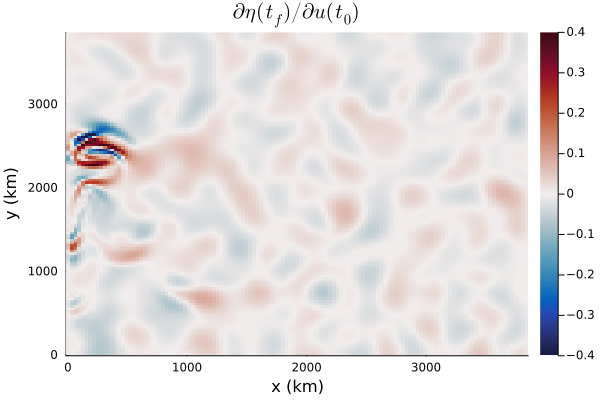

In [22]:
heatmap(LinRange(0, 3840, 127),
LinRange(0,3840, 128),
derivs.u', 
c=:balance,
clim=(-.4, .4),
xlabel=("x (km)"),
ylabel=("y (km)"),
title=(L"\partial \eta(t_f) / \partial u(t_0)")
)